
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

### Setup

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- xgboost
- scikit-learn
- [**shap**](https://github.com/slundberg/shap)
- [**pdpbox**](https://github.com/SauceCat/PDPbox)

In [ ]:
# ! pipenv install shap pdpbox

In [1]:
import IPython

In [2]:
DATA_PATH = '../data/'

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

### I. Wrangle the data

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import r2_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LinearRegression

In [4]:
def wrangle(DATA_PATH):
  df = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv', parse_dates=['issue_d']).set_index('issue_d')

  # Just use 36 month loans
  df = df[df.term==' 36 months']

  # Index & sort by issue date
  df = df.sort_index()

  # Clean data, engineer feature, & select subset of features
  df = df.rename(columns=                     
      {'annual_inc': 'annual_income', 
      'fico_range_high': 'credit_score', 
      'funded_amnt': 'loan_amount', 
      'title': 'loan_purpose'})

  df['interest_rate'] = df['int_rate'].str.strip('%').astype(float)
  df['monthly_debts'] = df['annual_income'] / 12 * df['dti'] / 100

  columns = ['annual_income', 
            'credit_score', 
            'loan_amount', 
            'loan_purpose', 
            'monthly_debts', 
            'interest_rate']

  df = df[columns]
  df = df.dropna()


  return df

In [5]:
df = wrangle(DATA_PATH)

In [6]:
df

,annual_income,credit_score,loan_amount,loan_purpose,monthly_debts,interest_rate
issue_d,,,,,,
2007-07-01,150000.0,779.0,5000.0,New kitchen,0.000000,7.43
2007-07-01,200000.0,679.0,3000.0,Roofdeck for my new NYC apartment,0.000000,10.28
2007-07-01,95000.0,774.0,5000.0,Mortgage Pre-Payment,303.208333,7.43
2007-07-01,20000.0,684.0,3500.0,Renting Apartment: Need security deposit,25.000000,10.28
2007-08-01,61800.0,749.0,4000.0,Apartment,178.190000,7.75
...,...,...,...,...,...,...
2019-03-01,80000.0,839.0,30000.0,Business,107.333333,6.46
2019-03-01,100000.0,729.0,5000.0,Debt consolidation,278.333333,12.40
2019-03-01,192000.0,704.0,7000.0,Debt consolidation,1100.800000,20.00


- Turn the high cardinality column to lower cardinality column

In [7]:
df['loan_purpose'].nunique()

6697

In [8]:
# for loop
# apply a function to this column
top_5_purposes = df['loan_purpose'].value_counts()[:5].index

In [9]:
def top_5(purpose):
    if purpose in top_5_purposes:
        return purpose
    else:
        return 'Other_purpose'

In [10]:
df['loan_purpose'] = df['loan_purpose'].apply(top_5)

In [11]:
df['loan_purpose'].value_counts()

Debt consolidation         48941
Credit card refinancing    20613
Other_purpose              18885
Home improvement            5730
Other                       5498
Major purchase              1961
Name: loan_purpose, dtype: int64

### II. Split the data

In [12]:
X = df.drop(columns='interest_rate')
y = df['interest_rate']

In [13]:
cutoff1 = int(len(df)* 0.6)
cutoff2 = int(len(df)* 0.8)

X_train, y_train = X.iloc[:cutoff1], y.iloc[:cutoff1]
X_val, y_val = X.iloc[cutoff1:cutoff2], y.iloc[cutoff1:cutoff2]
X_test, y_test = X.iloc[cutoff2:], y.iloc[cutoff2:]

### III. Set the baseline

In [14]:
from sklearn.metrics import r2_score
r2_score(y_train, [y_train.mean()]*len(y_train))

0.0

### IV.  Build the models

### Fit Linear Regression model

In [15]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SimpleImputer(),
                         LinearRegression())
model_lr.fit(X_train,y_train)

/Users/sisichen/.local/share/virtualenvs/Unit2-sprint3-ds25-B8QTsEAs/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['loan_purpose'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [16]:
r2_score(y_val, model_lr.predict(X_val))

0.20102475678215104

In [17]:
column = model_lr.named_steps['onehotencoder'].feature_names
coef = model_lr.named_steps['linearregression'].coef_

In [18]:
pd.Series(coef, index=column).sort_values()

loan_purpose_Credit card refinancing   -1.763469
loan_purpose_Debt consolidation        -0.378532
loan_purpose_Home improvement          -0.171387
credit_score                           -0.058065
loan_purpose_Major purchase            -0.041085
monthly_debts                          -0.000087
annual_income                          -0.000002
loan_amount                             0.000019
loan_purpose_Other_purpose              0.989555
loan_purpose_Other                      1.364918
dtype: float64

In [22]:
# if the income increase 10000, the interest rate will decrease 0.02%
delta_income = 10000
delta_interest_rate = delta_income*(-0.000002)

In [23]:
delta_interest_rate

-0.02

### Fit Gradient Boosting model


In [24]:
from xgboost import XGBRegressor
model_gb = make_pipeline(OrdinalEncoder(),
                         XGBRegressor(n_estimators=200, 
                                      objective='reg:squarederror', 
                                      n_jobs=-1))
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.2900706080657681


### Explaining Gradient Boosting???

Linear models have coefficients, but trees do not.

Instead, to see the relationship between individual feature(s) and the target, we can use partial dependence plots.

# Visualize and interpret partial dependence plots
## Overview

Partial dependence plots show the relationship between 1-2 individual features and the target — how predictions partially depend on the isolated features.

It's explained well by [PDPbox library documentation](https://pdpbox.readthedocs.io/en/latest/):

>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.


Let's also look at an [animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples):

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)


### Partial Dependence Plots with 1 feature

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)


In [25]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='annual_income'>})

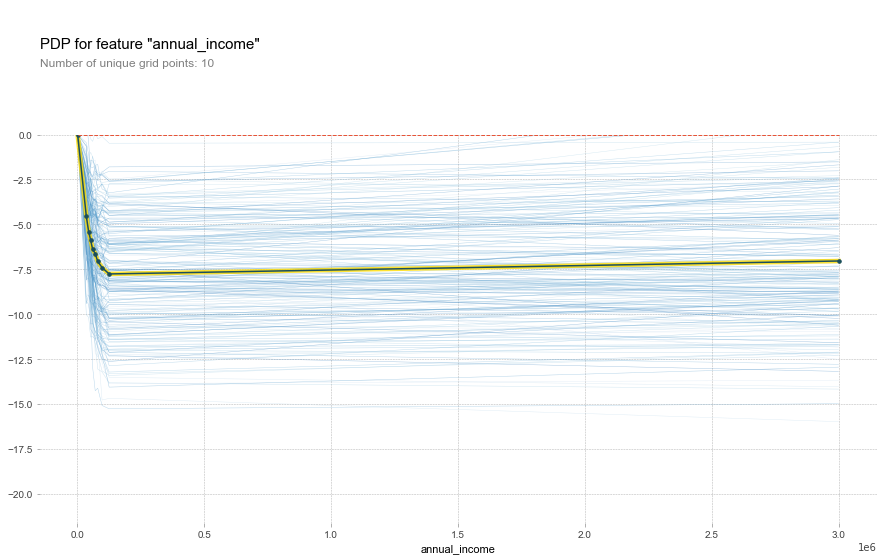

In [26]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'annual_income'

isolated = pdp_isolate(model=model_gb,
           dataset=X_val, 
           model_features=X_val.columns,
           feature= feature)

pdp_plot(isolated,feature_name=feature,plot_lines=True, frac_to_plot=0.01)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='annual_income'>})

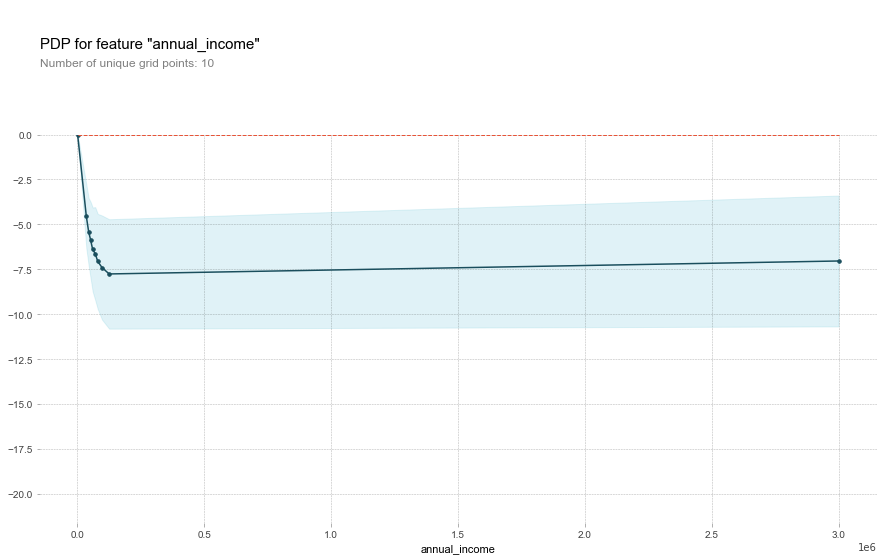

In [27]:
pdp_plot(isolated,feature_name=feature)

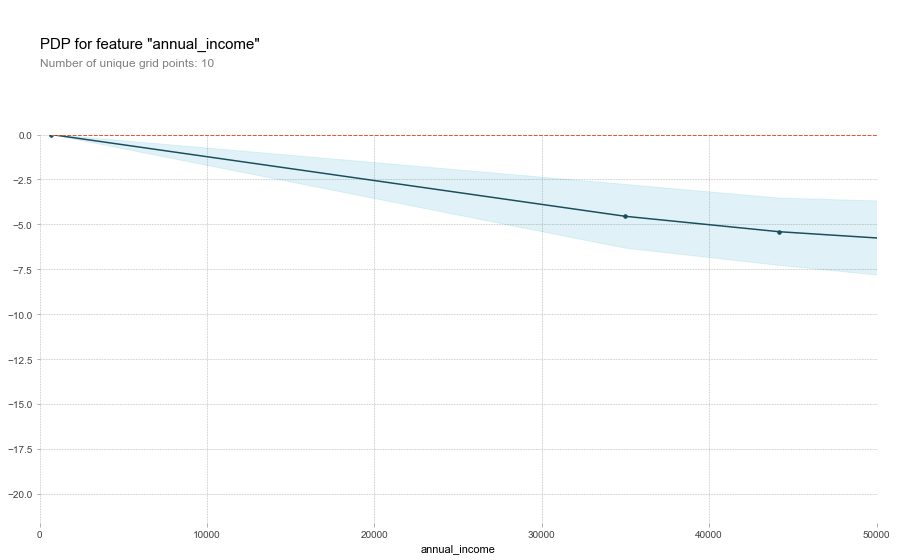

In [29]:
# just check the range that we are intested in 
pdp_plot(isolated,feature_name=feature)
plt.xlim((0, 50000));

### Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20 with some versions of matplotlib:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='annual_income', ylabel='credit_score'>})

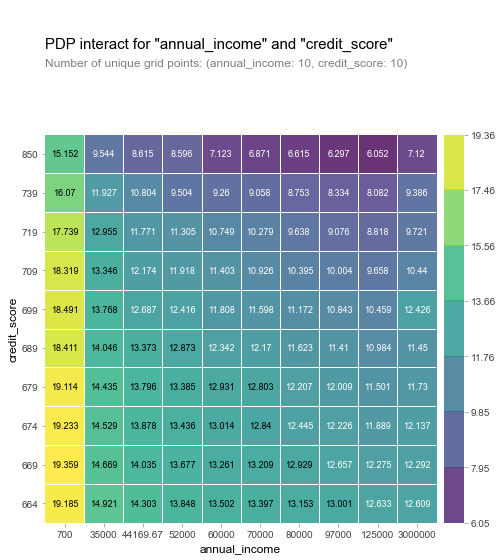

In [30]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['annual_income', 'credit_score']

interact = pdp_interact(model=model_gb,
           dataset=X_val, 
           model_features=X_val.columns,
           features= features)

pdp_interact_plot(interact, feature_names=features, plot_type='grid')

### BONUS: PDPs with categorical features

Just for your future reference, here's a bonus example to demonstrate partial dependence plots with categorical features.

1. I recommend you use Ordinal Encoder or Target Encoder, outside of a pipeline, to encode your data first. (If there is a natural ordering, then take the time to encode it that way, instead of random integers.) Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.


In [31]:
# retrain the model step by step, do not use pipeline
oe = OrdinalEncoder()
X_train_T = oe.fit_transform(X_train)
X_val_T = oe.transform(X_val)
model_gb = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)

In [32]:
model_gb.fit(X_train_T, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

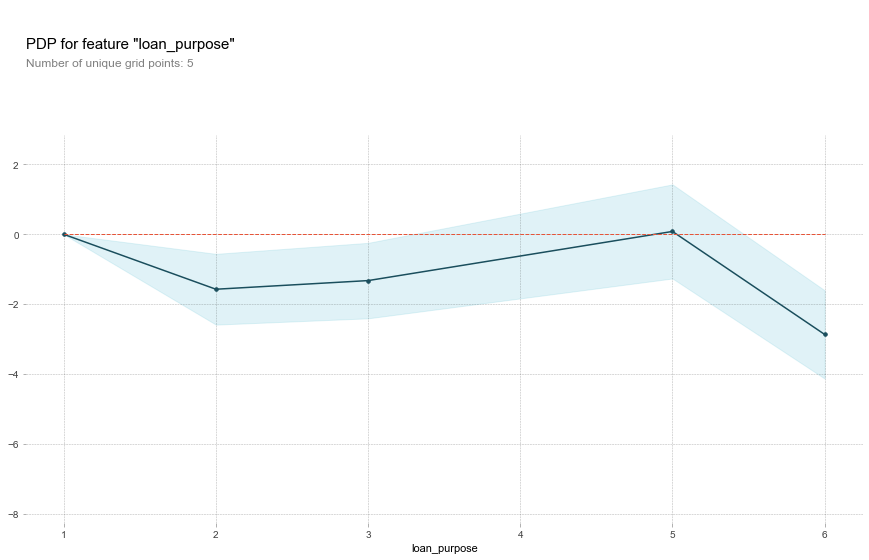

In [33]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
feature = 'loan_purpose'
isolated = pdp_isolate(model=model_gb, dataset=X_val_T, model_features=X_val_T.columns, feature=feature)
pdp_plot(isolated, feature);

In [37]:
# use the for loop below to map the numbers to class names
feature = 'loan_purpose'
for item in oe.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

In [38]:
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

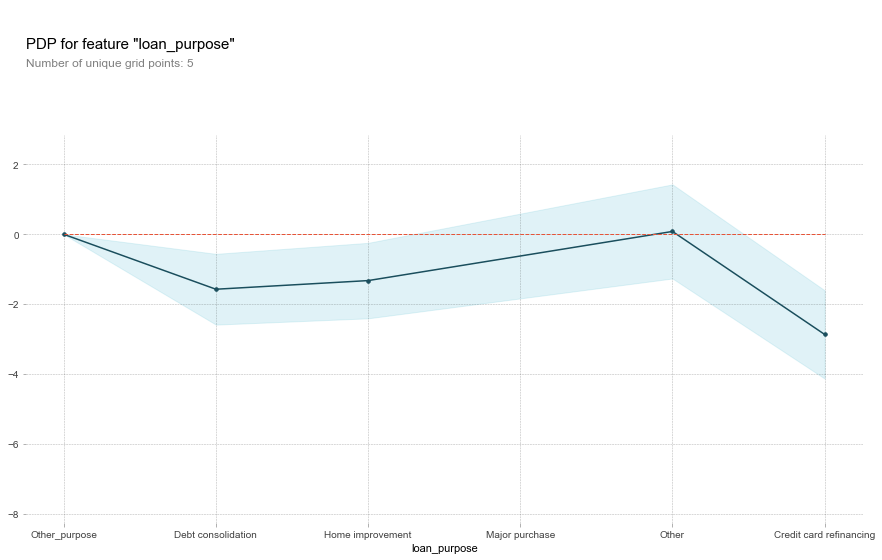

In [39]:
pdp_plot(isolated, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

# Explain individual predictions with shapley value plots

## Overview

We’ll use TreeExplainer from an awesome library called [SHAP](https://github.com/slundberg/shap), for “additive explanations” — we can explain individual predictions by seeing how the features add up!

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png" width="800" />

In [41]:
oe = OrdinalEncoder()
X_train_T = oe.fit_transform(X_train)
model_gb = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
model_gb.fit(X_train_T, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
# get one observation from X_test
row = X_test.iloc[[1]]
row = oe.transform(row)

In [43]:
row

,annual_income,credit_score,loan_amount,loan_purpose,monthly_debts
issue_d,,,,,
2016-12-01,35000.0,664.0,3000.0,2,336.0


In [44]:
model_gb.predict(row)

array([13.677742], dtype=float32)

In [49]:
import shap

explainer = shap.TreeExplainer(model_gb) # do not like pipeline
shap_values = explainer.shap_values(row)
shap_values 

array([[ 0.62617767,  1.7903335 ,  0.2938971 , -0.17205845, -0.4476796 ]],
      dtype=float32)

In [50]:
# The expected value for target variable
y_train.mean(), model_gb.predict(X_train_T).mean()

(11.58710787850958, 11.587075)

In [51]:
shap.initjs()
shap.force_plot(
                base_value=explainer.expected_value,
                shap_values=shap_values,
                features=row)

## References

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

## Recap

You learned about three types of model explanations during the past 1.5 lessons:

#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### 3. Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

## Challenge

Complete these tasks for your project, and document your work.

- Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- Make at least 1 partial dependence plot to explain your model.
- Make at least 1 Shapley force plot to explain an individual prediction.
- **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).